In [ ]:
import torch
from torch import Tensor
import numpy as np
import pandas as pd
print(torch.__version__)

1.13.1+cu116


In [ ]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/nightly/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-lb5znog7
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-lb5znog7
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit e4966f1d1317d8018460415e8d6c6e46e10fbe33
  Installing build dependencies ... done
  Getting requirem

## Heterogeneous Graph Creation

First, we download the dataset to an arbitrary folder (in this case, the current directory):

In [ ]:
# Import everything
from torch_geometric.data import download_url, extract_zip
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score,roc_auc_score, precision_score
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt
# device = torch.device("cuda:0")
# torch.set_default_tensor_type(device)

Before we create the heterogeneous graph, let’s take a look at the data.

In [ ]:
edge_url="https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/edges_191120.csv"
edges_df=pd.read_csv(edge_url)
print(edges_df.edge_type.value_counts())
##########################################
edges_df = edges_df.iloc[:111355,:]
##########################################
edges_df.head()

ingr-ingr     111355
ingr-fcomp     35440
ingr-dcomp       384
Name: edge_type, dtype: int64


,id_1,id_2,score,edge_type
0,5063,6083,0.337742,ingr-ingr
1,244,4620,0.093855,ingr-ingr
2,2253,6753,0.107870,ingr-ingr
3,2813,6228,0.092569,ingr-ingr
4,3016,6314,0.123897,ingr-ingr


We have over a hundred thousand ingredient ingredient edges, let' just use that data for prediction.

In [ ]:
# Check we only too the right edges
print(edges_df.edge_type.value_counts())

ingr-ingr    111355
Name: edge_type, dtype: int64


In [ ]:
# Include nodes
node_url="https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/nodes_191120.csv"
nodes_df=pd.read_csv(node_url)
print(nodes_df.shape)
nodes_df.head()

(8298, 5)


,node_id,name,id,node_type,is_hub
0,0,1%_fat_buttermilk,NaN,ingredient,no_hub
1,1,1%_fat_cottage_cheese,NaN,ingredient,no_hub
2,3,10%_cream,NaN,ingredient,no_hub
3,4,100%_bran,NaN,ingredient,no_hub
4,5,10_inch_flour_tortilla,NaN,ingredient,no_hub


In [ ]:
# How many types do we have
nodes_df.node_type.value_counts()

ingredient    6653
compound      1645
Name: node_type, dtype: int64

In [ ]:
# Just take the ingredients
nodes_df = nodes_df[nodes_df['node_id'].isin(
    (set(edges_df.id_1.values).union(set(edges_df.id_2.values))))]
nodes_df.node_type.value_counts()

ingredient    6653
Name: node_type, dtype: int64

In [ ]:
# This block just loads the data

flavorGraph = Data()
# flavorGraph = flavorGraph.to(device)

edge_weight = torch.Tensor(edges_df.score.values)
node_index = torch.Tensor(nodes_df.node_id.values)

node_map = dict()
for i in range(len(node_index)):
  node_map[(int(node_index[i]))] = i

edge_index = torch.Tensor([edges_df.id_1.apply(lambda x: node_map[x]).values,
                           edges_df.id_2.apply(lambda x: node_map[x]).values])

flavorGraph.x = node_index.view(node_index.size(0), -1)
flavorGraph.edge_index = edge_index.type(torch.int64)
flavorGraph.edge_weight = edge_weight

flavorGraph.validate(raise_on_error=True)
flavorGraph = ToUndirected()(flavorGraph)

print(flavorGraph.is_undirected())

# TrainTest Split for Edge Prediction
transform = RandomLinkSplit(is_undirected=True,add_negative_train_samples=False,disjoint_train_ratio=0.35)

train_data, val_data,test_data = transform(flavorGraph)

True


In [ ]:
train_data, val_data, test_data

(Data(x=[6653, 1], edge_index=[2, 101334], edge_weight=[101334], edge_label=[27282], edge_label_index=[2, 27282]),
 Data(x=[6653, 1], edge_index=[2, 155898], edge_weight=[155898], edge_label=[22270], edge_label_index=[2, 22270]),
 Data(x=[6653, 1], edge_index=[2, 178168], edge_weight=[178168], edge_label=[44542], edge_label_index=[2, 44542]))

wow look at us we did it.

We see that the edges are undirected with id of nodes, the type of connection, and the weight between the nodes.

In [ ]:
# Define the main class of the model
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # The main GNN layers, two graph conv layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    # Simple dot product based decoder
    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    # def decode_all(self, z):
    #     prob_adj = z @ z.t()
    #     return (prob_adj > 0).nonzero(as_tuple=False).t()

    # Want probabilities out to easily interpret results
    def decode_all(self, z):
      prob_adj = z @ z.t()
      prob_adj = torch.sigmoid(prob_adj)  # Apply sigmoid function to get probabilities
      return prob_adj

model = Net(flavorGraph.num_features, 128, 64)
# model.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    y = data.edge_label.cpu().numpy()
    pred = out.cpu().numpy()
    return roc_auc_score(y, pred)

validationMetrics_GCN = []

best_val_auc = final_test_auc = 0
for epoch in range(1, 150):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    validationMetrics_GCN.append([val_auc, test_auc])
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_probs_GCN = model.decode_all(z)

Epoch: 001, Loss: 4112019.5000, Val: 0.5000, Test: 0.5000
Epoch: 002, Loss: 1317638.1250, Val: 0.5000, Test: 0.5000
Epoch: 003, Loss: 405787.5625, Val: 0.5000, Test: 0.5000
Epoch: 004, Loss: 437794.3125, Val: 0.5000, Test: 0.5000
Epoch: 005, Loss: 650239.5625, Val: 0.5000, Test: 0.5000
Epoch: 006, Loss: 695464.5000, Val: 0.5000, Test: 0.5000
Epoch: 007, Loss: 598844.8750, Val: 0.5000, Test: 0.5000
Epoch: 008, Loss: 467914.7812, Val: 0.5000, Test: 0.5000
Epoch: 009, Loss: 348674.6562, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 261872.5938, Val: 0.5000, Test: 0.5000
Epoch: 011, Loss: 201963.5469, Val: 0.5000, Test: 0.5000
Epoch: 012, Loss: 160028.9688, Val: 0.5000, Test: 0.5000
Epoch: 013, Loss: 129191.5625, Val: 0.5000, Test: 0.5000
Epoch: 014, Loss: 109327.7109, Val: 0.5000, Test: 0.5000
Epoch: 015, Loss: 95436.3438, Val: 0.5000, Test: 0.5000
Epoch: 016, Loss: 88295.1641, Val: 0.5000, Test: 0.5000
Epoch: 017, Loss: 81400.1953, Val: 0.5000, Test: 0.5000
Epoch: 018, Loss: 75072.1562, Va

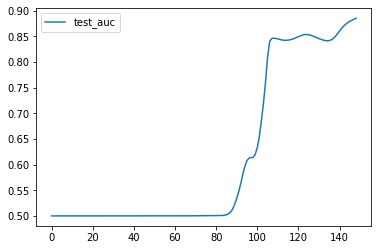

In [ ]:
plt.plot(np.arange(len(validationMetrics_GCN)),np.array(validationMetrics_GCN)[:,1],label='test_auc')
plt.legend()
plt.show()

In [ ]:
start_node = np.random.randint(0, 6653)
for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
  top_nodes = nodes_df.iloc[final_edge_probs_GCN.topk(10, dim=1).indices[start_node, ]]
  which_one = np.random.randint(0, 10)
  start_node_id = top_nodes.iloc[which_one]["node_id"]
  print(top_nodes.iloc[which_one]["name"])

water
olive_oil
garlic_clove
egg
salt


In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    # def decode_all(self, z):
    #     prob_adj = z @ z.t()
    #     return (prob_adj > 0).nonzero(as_tuple=False).t()

    def decode_all(self, z):
      prob_adj = z @ z.t()
      prob_adj = torch.sigmoid(prob_adj)  # Apply sigmoid function to get probabilities
      return prob_adj

model = Net(flavorGraph.num_features, 128, 64)
# model.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    y = data.edge_label.cpu().numpy()
    pred = out.cpu().numpy()
    return roc_auc_score(y, pred)

validationMetrics_SAGE = []


best_val_auc = final_test_auc = 0
for epoch in range(1, 150):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    validationMetrics_SAGE.append([val_auc, test_auc])
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_probs_SAGE = model.decode_all(z)

Epoch: 001, Loss: 46386056.0000, Val: 0.5000, Test: 0.5000
Epoch: 002, Loss: 87458104.0000, Val: 0.5000, Test: 0.5000
Epoch: 003, Loss: 27607044.0000, Val: 0.5000, Test: 0.5000
Epoch: 004, Loss: 26463712.0000, Val: 0.5000, Test: 0.5000
Epoch: 005, Loss: 45629612.0000, Val: 0.5000, Test: 0.5000
Epoch: 006, Loss: 35805116.0000, Val: 0.5026, Test: 0.5010
Epoch: 007, Loss: 15410822.0000, Val: 0.5088, Test: 0.5041
Epoch: 008, Loss: 6661700.0000, Val: 0.5057, Test: 0.5030
Epoch: 009, Loss: 12266449.0000, Val: 0.5027, Test: 0.5014
Epoch: 010, Loss: 20192092.0000, Val: 0.5023, Test: 0.5008
Epoch: 011, Loss: 20174752.0000, Val: 0.5028, Test: 0.5014
Epoch: 012, Loss: 13320724.0000, Val: 0.5063, Test: 0.5045
Epoch: 013, Loss: 6232532.5000, Val: 0.5078, Test: 0.5039
Epoch: 014, Loss: 3977639.5000, Val: 0.5041, Test: 0.5024
Epoch: 015, Loss: 5439375.0000, Val: 0.5000, Test: 0.5000
Epoch: 016, Loss: 8218051.5000, Val: 0.5000, Test: 0.5000
Epoch: 017, Loss: 8876316.0000, Val: 0.5000, Test: 0.5000
Epo

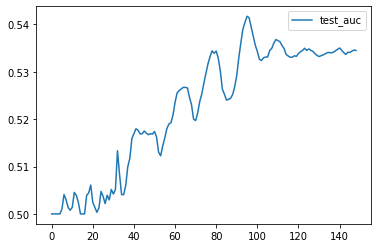

In [ ]:
plt.plot(np.arange(len(validationMetrics_SAGE)),np.array(validationMetrics_SAGE)[:,1],label='test_auc')
plt.legend()
plt.show()

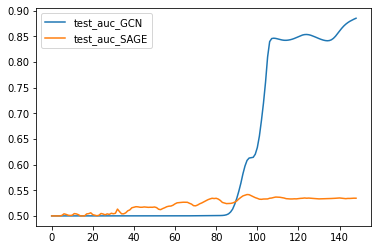

In [ ]:
plt.plot(np.arange(len(validationMetrics_GCN)),np.array(validationMetrics_GCN)[:,1],label='test_auc_GCN')
plt.plot(np.arange(len(validationMetrics_SAGE)),np.array(validationMetrics_SAGE)[:,1],label='test_auc_SAGE')
plt.legend()
plt.show()

In [ ]:
start_node = np.random.randint(0, 6653)
for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
  top_nodes = nodes_df.iloc[final_edge_probs_SAGE.topk(10, dim=1).indices[start_node, ]]
  which_one = np.random.randint(0, 10)
  start_node_id = top_nodes.iloc[which_one]["node_id"]
  print(top_nodes.iloc[which_one]["name"])

angelica
baby_chicken
arctic_char
apricot_fruit_spread
apricot_liqueur
apple_chip
